# DATA 201
* Operate on 16000 GenCode 34 seqs.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
K=1

## Sequence Length Distributions

In [3]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [4]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [5]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [6]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Train on RNA lengths 200-1Kb

In [7]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
print("Ready: train_set")
#train_set
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Data reshape


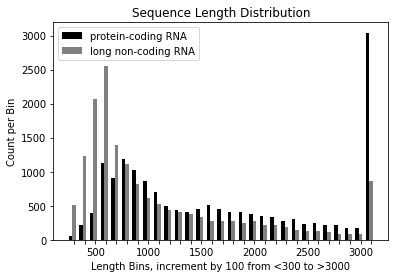

In [8]:
nc_lens = np.sort(nc_seq['seqlen'])
pc_lens = np.sort(pc_seq['seqlen'])
series = np.linspace(200,3000,29)
series = np.append(series,[200000])
nc_heights,bin_edges = np.histogram(nc_lens,bins=series)
pc_heights,bin_edges = np.histogram(pc_lens,bins=series)
bin_max=bin_edges[1:]  # there are #bars+1 edges; discard left edge
bin_num=[]
labels=[]
pc_num=[]
nc_num=[]
for i in range(len(bin_max)):
    pc_num.append(3*i)  # draw bar in first third of column
    nc_num.append(3*i+1)  # draw bar in second third of column
    bin_num.append(i)
    if i%5==2:   # place X-label at 500, 1000, etc.
        labels.append(int(bin_max[i]))
    else:
        labels.append(None)
wid=1
plt.bar(pc_num,pc_heights,wid,tick_label=labels,color='black',
        label='protein-coding RNA')
plt.bar(nc_num,nc_heights,wid,tick_label=labels,color='gray',
        label='long non-coding RNA')
plt.title('Sequence Length Distribution')
plt.ylabel('Count per Bin')
plt.xlabel('Length Bins, increment by 100 from <300 to >3000')
plt.legend()
plt.show()


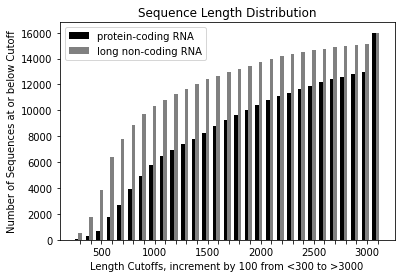

In [9]:
nc_cum_counts=[]
for i in range(len(bin_max)):
    nc_cum_counts.append((nc_lens<bin_max[i]).sum()) 
pc_cum_counts=[]
for i in range(len(bin_max)):
    pc_cum_counts.append((pc_lens<bin_max[i]).sum()) 

plt.bar(pc_num,pc_cum_counts,wid,tick_label=labels,color='black',
        label='protein-coding RNA')
plt.bar(nc_num,nc_cum_counts,wid,tick_label=labels,color='gray',
        label='long non-coding RNA')
plt.title('Sequence Length Distribution')
plt.ylabel('Number of Sequences at or below Cutoff')
plt.xlabel('Length Cutoffs, increment by 100 from <300 to >3000')
plt.legend()
plt.show()
